# Logistic map explorations (Taylor and beyond)

Adapted by Dick Furnstahl from the Ipython Cookbook by Cyrille Rossant.
Lyapunov plot modified on 29-Jan-2019 after discussion with Michael Heinz.

Here we consider the *logistic map*, which illustrates how chaos can arise from a simple nonlinear equation.  The logistic map models the evolution of a population including reproduction and mortality (see Taylor section 12.9).

The defining function for the logistic map is

$ f_r(x) = r x (1-x) \;, $

where $r$ is the control parameter analogous to $\gamma$ for the damped, driven pendulum.  To study the pendulum, we looked at $\phi(t)$ at $t_0$, $t_0 + \tau$, $t_0 + 2\tau$, and so on, where $\tau$ is the driving frequency and we found $\phi(t_0 + \tau)$ from $\phi(t_0)$ by solving the differential equation for the pendulum.  After transients had died off, we characterized the value of $\gamma$ being considered by the periodicity of the $\phi(t_n)$ values: period one (all the same), period two (alternating), chaotic (no repeats) and so on.

Here instead of a differential equation telling us how to generate a trajectory, we use $f_r(x)$:

$\begin{align}
  x_1 = f_r(x_0) \ \rightarrow\ x_2 = f_r(x_1) \ \rightarrow\  x_3 = f_r(x_2) \ \rightarrow\  \ldots
\end{align}$

There will be transients at the beginning, but this sequence of $x_i$ values may reach a point $x = x^*$ such that $f(x^*) = x^*$. We call this a *fixed point*.  If instead it ends up bouncing between two values of $x$, it is period two and we call it a two-cycle.  We can have a cascade of period doubling, as found for the damped, driven pendulum, leading to chaos, which is characterized by the mapping never repeating.  We can make a corresponding bifurcation diagram and identify Lyapunov exponents for each initial condition and $r$.

To adapt this notebook to a different map (such as the sine map), you will need to:
* Change the map function and its derivative.
* Change the range of the $r$ parameter to an appropriate range for the new map.
* Possibly change the initial $x$ value ($x_0$).
* Modify the limits of the plots appropriately.

In [8]:
%matplotlib inline

# standard numpy and matplotlib imports
import numpy as np
import matplotlib.pyplot as plt


In [9]:
def logistic(r, x):
    """Logistic map function: f(x) = r x(1-x)
    """
    return r * x * (1.-x)

def logistic_deriv(r, x):
    """Logistic map derivative: f'(x) = r(1-2x)
    """
    return r * (1. - 2.*x)

## Explore the logistic map and its fixed points

Start with a simple plot of the logistic function.  **What does changing $r$ do?**

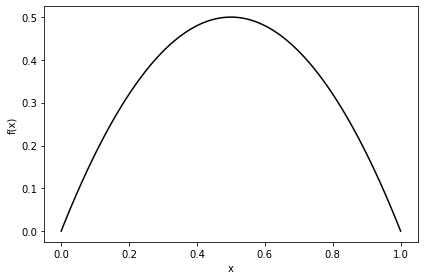

In [10]:
x, step = np.linspace(0,1, num=101, endpoint=True, retstep=True)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

r_param = 2
ax.plot(x, logistic(r_param, x), 'k-')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')

fig.tight_layout()

Make plots showing the approach to fixed points.  

**Play with the number of steps taken and the values of $r$.**  
1. **Increase the number of steps in the plots to more cleanly identify the long-time trend for that value of $r$.**
2. **Try smaller values of $r$.  Are there always non-zero fixed points for small $r$?**


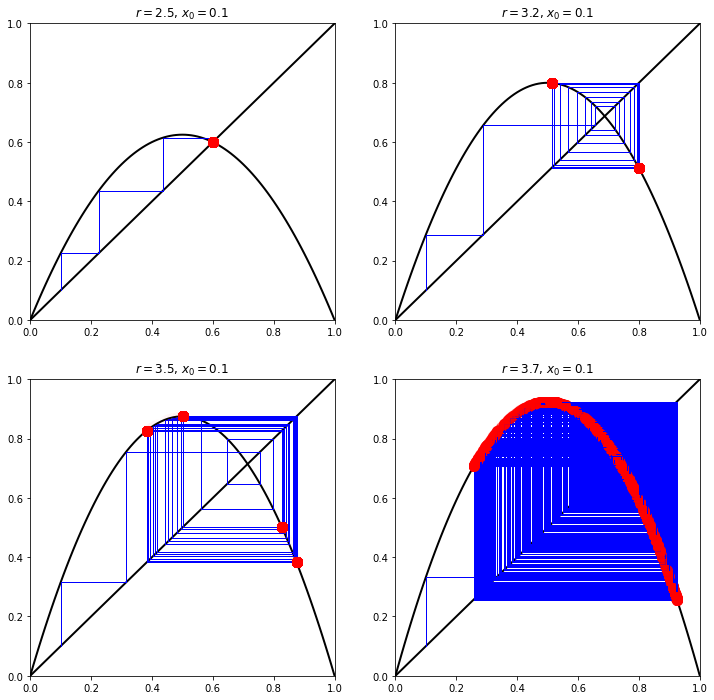

In [15]:
def plot_system(r, x0, n, ax=None):
    """Plot the function and the y=x diagonal line."""
    t = np.linspace(0,1, num=101)
    ax.plot(t, logistic(r,t), 'k', lw=2)  # black, linewidth 2
    ax.plot([0,1], [0,1], 'k', lw=2)  # x is an array of 0 and 1, 
                                      # y is the same array, so this plots 
                                      #  a straight line from (0,0) to (1,1).
    
    # Recursively apply y=f(x) and plot two additional straight lines:
    #   line from (x, x) to (x, y)
    #   line from (x, y) to (y, y)
    x = x0
    for i in range(n):   # do n iterations, i = 0, 1, ..., n-1
        y = logistic(r, x)
        # Plot the two lines
        ax.plot([x,x], [x,y], color='blue', lw=1)
        ax.plot([x,y], [y,y], color='blue', lw=1)
        # Plot the positions with increasing opacity of the circles
        ax.plot([x], [y], 'or', ms=10, alpha=(i+1)/n)
        x = y  # recursive: reset x to y for the next iteration
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(f'$r={r:.1f}$, $x_0={x0:.1f}$')
                
fig = plt.figure(figsize=(12,12))

n_pts = 1000
ax1 = fig.add_subplot(2,2,1)
# start at 0.1, r parameter is 2.5, take n steps
plot_system(r=2.5, x0=0.1, n=n_pts, ax=ax1)  

ax2 = fig.add_subplot(2,2,2)
# start at 0.1, r parameter is 3.2, take n steps
plot_system(r=3.2, x0=0.1, n=n_pts, ax=ax2)

ax3 = fig.add_subplot(2,2,3)
# start at 0.1, r parameter is 2.6, take n steps
plot_system(r=3.5, x0=0.1, n=n_pts, ax=ax3)

ax4 = fig.add_subplot(2,2,4)
# start at 0.1, r parameter is 3.7, take n steps
plot_system(r=3.7, x0=0.1, n=n_pts, ax=ax4)

**What periods do these exhibit?  Are any chaotic?** 

## Find the unstable point numerically

To find the value of $r$ at which the second fixed point becomes unstable, we must solve simultaneously the equations (see Taylor 12.9 in the "A Test for Stability" subsection):

$\begin{align}
  &f_r(x^*) = x^* \\
  &f_r'(x^*) = -1
\end{align}$

where $f'$ means the derivative with respect to $x$, or

$\begin{align}
  &f_r(x^*) - x^* = 0 \\
  &f_r'(x^*) + 1 = 0
\end{align}$

It is the latter form of the equations that we will pass to the 
scipy function `fsolve` to find the values of $r$ and $x*$.

In [5]:
from scipy.optimize import fsolve  # Google this to learn more!

def equations(passed_args):
    """Return the two expressions that must equal to zero."""
    r, x = passed_args
    return (logistic(r, x) - x, logistic_deriv(r, x) + 1)

# Call fsolve with initial values for r and x
r, x = fsolve(equations, (0.5, 0.5))

print_string = f'x* = {x:.10f},  r = {r:.10f}'
print(print_string)

x* = 0.6666666667,  r = 3.0000000000


**Verify analytically that these are the correct values for the logistic map.**  We use this same procedure for other maps where only numerical solutions are known. 

## Now make the bifurcation diagram and calculate Lyapunov exponents

To make a bifurcation diagram, we:
* define an array of closely spaced $r$ values;
* for each $r$, iterate the map $x_{i+1} = f_r(x_i)$ a large number of times (e.g., 1000) to ensure convergence;
* plot the last 100 or so iterations as points at each $r$.

To think about how to calculate a Lyapunov exponent, consider two iterations of the map starting from two values of $x$ that are close together.  Call these initial values $x_0$ and $x_0 + \delta x_0$.  These are mapped by $f_r$ to $x_1$ and  $x_1 + \delta x_1$, then $x_2$ and $x_2 + \delta x_2$, up to $x_n + \delta x_n$. 

How are the $\delta x_i$ related?  Each $\delta x_i$ is small, so use a Taylor expansion!
Expanding $f(x)$ about $x_n$:

$\begin{align}
  f(x_i &+ \delta x_i) = &f(x_i) + \delta x_i f'(x_i) + \frac{1}{2}(\delta x_i)^2 f''(x_i) + \cdots \\
\end{align}$

so, neglecting terms of order $(\delta x_i)^2$ and higher, 

$\begin{align}
    x_{i+1} + \delta x_{i+1} \approx x_{i+1} + \delta x_i f'(x_i)
    \quad\mbox{or}\quad  \delta x_{i+1} \approx f'(x_i)\, \delta x_i \;.
\end{align}$

Iterating this result we get

$\begin{align}
  \delta x_1 &= f'(x_0)\, \delta x_0  \\
  \delta x_2 &= f'(x_1)\, \delta x_1 = f'(x_1)\times f'(x_0)\, \delta x_0  \\
  & \qquad\vdots  \\
  |\delta x_n| &= \left(\prod_{i=0}^{n-1} |f'(x_i)|\right) |\delta x_0| \;,
\end{align}$

where the last equation gives us the separation of two trajectories after $n$ steps $\delta x_n$ in terms of their
initial separation, $\delta x_0$.  (Why can we just take the absolute value of all the terms?)

We expect that this will vary exponentially at large $n$ like

$\begin{align}
  \left| \frac{\delta x_n}{\delta x_0} \right| = e^{\lambda n}
\end{align}$

and so we define the Lypunov exponent $\lambda$ by

$\begin{align}
  \lambda = \lim_{n\rightarrow\infty} \frac{1}{n} \sum_{i=1}^{n} \ln |f'(x_i)| \;,
\end{align}$

which in practice is well approximated by the sum for large $n$.

If $\lambda > 0$, then nearby trajectories diverge from each other exponentially at large $n$, which corresponds to chaos. However, if the
trajectories converge to a fixed point or a limit cycle, they will get closer together with increasing $n$, which corresponds to $\lambda<0$.

Ok, let's do it!

In [6]:
n = 10000   
# Here we'll use n values of r linearly spaced between 2.8 and 4.0
###  You may want to change the range of r for other maps
r = np.linspace(2.8, 4.0, n)  

iterations = 1000   # iterations of logistic map; keep last iterations
last = 100          #  where results should have stabilized

x = 0.1 * np.ones(n)  # x_0 initial condition 
                      ### (you may want to change for other maps)

lyapunov = np.zeros(n) # initialize vector used for the Lyapunov sums

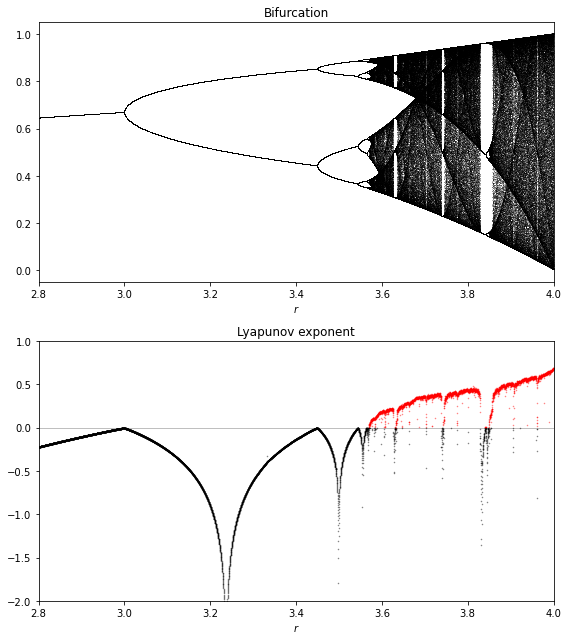

In [7]:
fig = plt.figure(figsize=(8,9))
ax1 = fig.add_subplot(2,1,1)   # bifurcation diagram
ax2 = fig.add_subplot(2,1,2)   # Lyapunov exponent

# Display the bifurcation diagram with one pixel per point x_n^(r) for last iterations
for i in range(iterations):
    x = logistic(r,x)  # just iterate: x_{i+1} = f_r(x_i)
    
    # Compute the partial sum of the Lyapunov exponent, which is the sum
    #  of derivatives of the logistic function (absolute value)
    lyapunov += np.log(abs(logistic_deriv(r,x)))
    # Display the bifurcation diagram.
    if i >= (iterations-last):  # only plot the last iterations 
        ax1.plot(r, x, ',k', alpha=0.25)
ax1.set_xlim(2.8, 4)
ax1.set_xlabel(r'$r$')
ax1.set_title("Bifurcation")

# Display the Lyapunov exponent

# Negative Lyapunov exponent
ax2.plot(r[lyapunov < 0], 
         lyapunov[lyapunov < 0] / iterations, 'o',
         color='black', alpha=0.5, ms=0.5)
# Positive Lyapunov exponent
ax2.plot(r[lyapunov >= 0], 
         lyapunov[lyapunov >= 0] / iterations, 'o',
         color='red', alpha=0.5, ms=0.5)

# Add a zero line (lightened with alpha=0.5)
ax2.axhline(0, color='k', lw=0.5, alpha=0.5)

ax2.set_xlim(2.8, 4)
ax2.set_ylim(-2, 1)
ax2.set_xlabel(r'$r$')
ax2.set_title("Lyapunov exponent")

plt.tight_layout()

We see there is a fixed point for $r < 3$, then two and four periods and a chaotic behavior when $r$ belongs to certain areas of the parameter space.  **Do the values of $r$ where these behaviors occur agree with what you found in the plots with particular $r$ values?** 

As for the pendulum, the Lyapunov exponent is positive when the system is chaotic (in red).  **Do these regions look consistent with the characteristics of chaos?**